### Ниже - учебный кейс по проведению A/B-тестов в рамках курса Аналитик Данных, Karpov Courses.

Применение однофакторного и двухфакторного дисперсионного анализа с последующим применением парных t-тестов. Данные сгенерированные.

In [60]:
import pandas as pd
import numpy as np
import requests
from urllib.parse import urlencode

import scipy
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from scipy.special import comb

import pingouin as pg

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale = 1.5, style = 'whitegrid', rc = {'figure.figsize' : (20,8)})

Вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 

Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый

Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

In [61]:
# Загрузка данных

# test 1

# id – id клиента в эксперименте
# group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные 10:10, C – прямоугольные 12:4)
# events – сколько блюд суммарно было заказано за период

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/rdJGNK66pHSJPA' 
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
test_1 = pd.read_csv(download_url)

if test_1.isna().sum().sum() != 0:
    print('\nALERT!!!\n')

print(test_1.shape)    
print(test_1.dtypes)

test_1.head(2)

(30000, 3)
id         int64
group     object
events     int64
dtype: object


,id,group,events
0,16046,A,14
1,18712,A,41


In [62]:
# Загрузка данных

# test 2

# id – id клиента в эксперименте
# segment – сегмент (high/low)
# group – вид кнопки (control – старая версия, test – новая версия)
# events – сколько блюд суммарно было заказано за период

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/VNm7NNw7HJFLPA' 
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
test_2 = pd.read_csv(download_url)

if test_2.isna().sum().sum() != 0:
    print('ALERT!!!')

print(test_2.shape)    
print(test_2.dtypes)

test_2.head(2)

(100000, 4)
id           int64
group       object
segment     object
events     float64
dtype: object


,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0


### Первый тест: 

- нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего.

Проверим структуру данных. 

In [63]:
test_1.groupby('id').agg({'events':'sum'})

,events
id,
0,29
1,46
2,20
3,64
4,34
...,...
29995,21
29996,48
29997,39


При группировке по id пользователя мы видим то же количество строк, что в исходном датафрейме. Это говорит о том, что каждая строка - уникальный пользователь.

Для начала посмотрим на форму распределения количества заказанных блюд по типам 

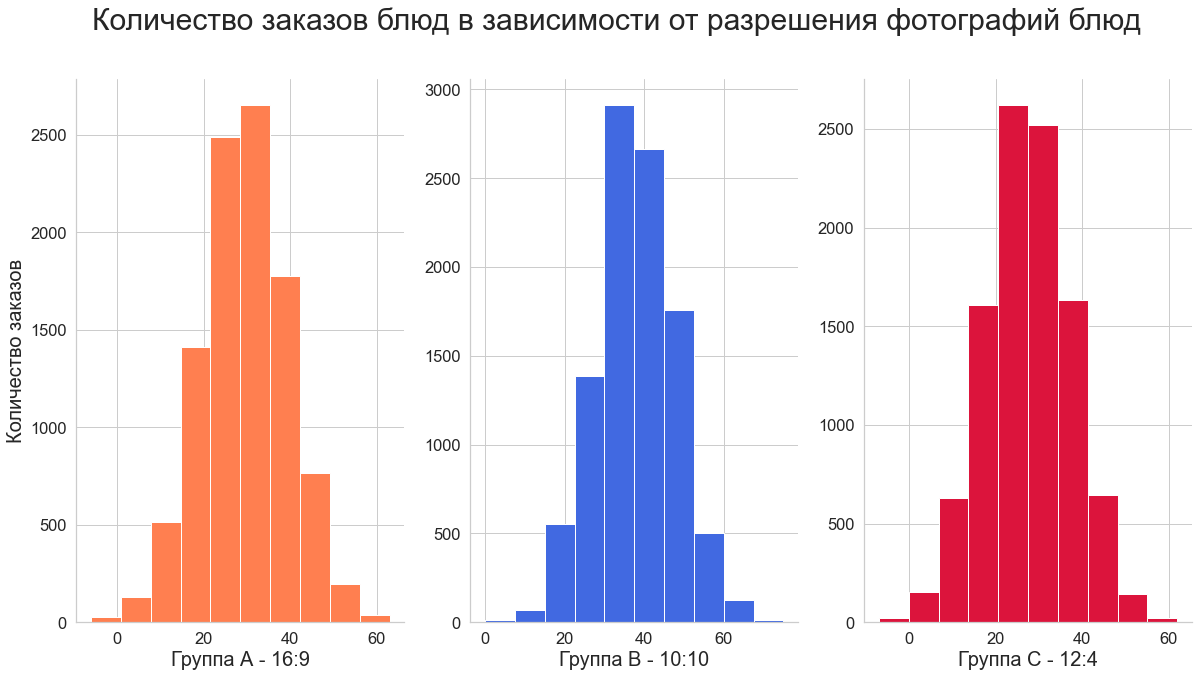

In [64]:
fig, axes = plt.subplots(1,3,figsize = (20, 10))

test_1.query('group == "A"').events.hist(ax = axes[0], color = 'coral')
test_1.query('group == "B"').events.hist(ax = axes[1], color = 'royalblue')
test_1.query('group == "C"').events.hist(ax = axes[2], color = 'crimson')
axes[0].set_ylabel('Количество заказов', fontsize = 20)
axes[0].set_xlabel('Группа А - 16:9', fontsize = 20)
axes[1].set_xlabel('Группа B - 10:10', fontsize = 20)
axes[2].set_xlabel('Группа С - 12:4', fontsize = 20)
fig.suptitle('Количество заказов блюд в зависимости от разрешения фотографий блюд', fontsize = 30)
sns.despine()

Все три распределения имеют признаки нормального распределения. Несмотря на это, уже на данной стадии заметно изменение количества заказов в середине распределения группы B.

Для определения различия средних между группами возпользуемся однофакторным дисперсионным анализом. Убедимся в том, что применение данного метода оправдано.

Для применения ANOVA необходимо:

- Достаточное количество наблюдений в выборках, не менее 30. В нашем случае требование выполняется.
- Не должно нарушаться требование о гомогенности дисперсий распределений.
- Не должно нарушаться требование о нормальности распределений.

Проверим гомогенность дисперсий с помощью теста Левина.

In [65]:
print('P-value о гомогенности дисперсий -',
    round(ss.levene(test_1.query('group == "A"').events,
                    test_1.query('group == "B"').events,
                    test_1.query('group == "C"').events)[1],5))

P-value о гомогенности дисперсий - 0.10413


Уровень значимости превышает 0.05, что не позволяет нам отвергнуть нулевую гипотезу о гомогенности дисперсий данных распределений.

Проверим распределения на нормальность. Нулевая гипотеза в данном случае утверждает следущее: "Генеральная совокупность, из которой извлечена данная выборка, распределена нормально."

In [66]:
print('P-value о проверке на нормальность группы А -',
    round(ss.normaltest(test_1.query('group == "A"').events)[1],5))
print('P-value о проверке на нормальность группы B -',
    round(ss.normaltest(test_1.query('group == "B"').events)[1],5))
print('P-value о проверке на нормальность группы C -',
    round(ss.normaltest(test_1.query('group == "C"').events)[1],5))

P-value о проверке на нормальность группы А - 0.34933
P-value о проверке на нормальность группы B - 0.65669
P-value о проверке на нормальность группы C - 0.19753


Каждый уровень значимости превышает 0.05, это значит что мы не можем отвергнуть нулевую гипотезу о том, что хотя бы один из этих признаков в генеральной совокупности не распределен нормально. Следовательно, так как наша выборки достаточно велики, мы также не можем утверждать что они не распределены нормальным образом.
Учитывая это, а также гистограммы распределения признаков, мы можем говорить о том, что наше количество заказов распределено нормальным образом во всех трех группах.

Все требования для проведения однофакторного анализа соблюдаются, применение ANOVA оправдано. Посмотрим на результаты.

In [67]:
pg.anova(data = test_1, dv = 'events', between = 'group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


Уровень значимости однофакторного дисперсионного анализа равен 0. Это говорит о том, что хотя бы одно из средних значений наших групп статистически значимо отличается от другого.

Применим критерий Тьюки для определения этих групп.

In [68]:
pg.pairwise_tukey(data = test_1, dv = 'events', between = 'group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.018089


Критерий Тьюки показывает, что для каждой из пар наших групп уровень значимости равен нулю. 

Попробуем подтвердить эти данные или найти повод для сомнений. Проверим это вычисление с помощью парного t-теста с поправкой Бонферони и с помощью теста Геймса-Хоувелла.

In [69]:
pg.pairwise_ttests(data = test_1, dv = 'events', between = 'group', padjust = 'bonf')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,2.250078e-49,bonf,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,1.024138


In [70]:
pg.pairwise_gameshowell(data = test_1, dv = 'events', between = 'group')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140920,-57.011134,19987.258491,6.412648e-13,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.141696,14.886135,19995.116233,6.349254e-12,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140062,72.420220,19995.502469,0.000000e+00,1.024138


Другим тестам удалось найти пренебрежимо малые p-value для равенства средних наших распределений. Несмотря на это, мы уверенно отвергаем нулевые гипотезы о равенстве средних в каждой из наших пар групп.

Вывод - применение фотографий квадратного формы статистически значимо увеличивает количество заказов.

### Второй тест: 

- Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

Цель исследования - проверка влияние одного фактора. Однако в данном случае на количество заказов может влиять и другой фактор - в каком сегменте пользователей находится наш покупатель.

In [71]:
test_2

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


Проверим структуру данных.

In [72]:
test_2.groupby('id').agg({'events':'sum'})

,events
id,
0,28.0
1,31.0
2,37.0
3,23.0
4,29.0
...,...
99995,27.0
99996,69.0
99997,22.0


Количество строк также не изменилось. Мы снова имеем дело с таблицей, где каждая строка - уникальный пользователь.

In [73]:
print(test_2.segment.value_counts())
print(test_2.group.value_counts())

low     80000
high    20000
Name: segment, dtype: int64
test       50000
control    50000
Name: group, dtype: int64


In [74]:
# Разобьем исходный датафрейм
test_2_tg = test_2.query('group == "test"')
test_2_cg = test_2.query('group == "control"')

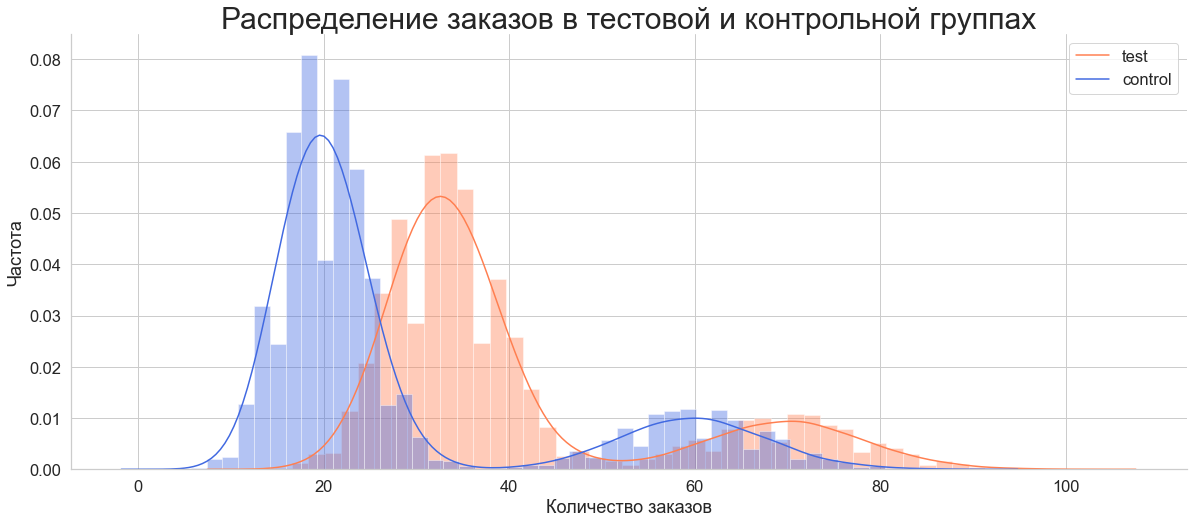

In [75]:
# Построим визуализацию.
bx = sns.distplot(test_2_tg.events, color = 'coral')
bx = sns.distplot(test_2_cg.events, color = 'royalblue')
legend = ('test', 'control')
bx.legend(legend)
bx.set_title('Распределение заказов в тестовой и контрольной группах', fontsize = 30)
bx.set_xlabel('Количество заказов')
bx.set_ylabel('Частота')
sns.despine()

Проанализируем наши распределения. 

- Первое что бросается в глаза - очевидная ненормальность распределений. Мы имеем большое количество значений в области малого количества заказов, затем спад практически до нуля в обоих случаях, и затем небольшой рост.
- Можно заметить схожесть наших распределений. В определенном смысле, распределение в тестовой группе выглядит как "сдвинутое" распределение контрольной группы, причем в каждой из областей сделанных заказов.

Определим некоторые параметры каждого из распределений по каждому из сегментов.

In [76]:
d = {'segment': ['low', 'high','low', 'high'], 
     'group'  : ['test', 'test','control', 'control'],
     'mean'   : [
                round(test_2_tg.query('segment == "low"').events.mean(),2),
                round(test_2_tg.query('segment == "high"').events.mean(),2),
                round(test_2_cg.query('segment == "low"').events.mean(),2),
                round(test_2_cg.query('segment == "high"').events.mean(),2)
                ],
     'median' : [
                round(test_2_tg.query('segment == "low"').events.median(),2),
                round(test_2_tg.query('segment == "high"').events.median(),2),
                round(test_2_cg.query('segment == "low"').events.median(),2),
                round(test_2_cg.query('segment == "high"').events.median(),2)
                ], 
     'std'    : [
                round(test_2_tg.query('segment == "low"').events.std(),2),
                round(test_2_tg.query('segment == "high"').events.std(),2),
                round(test_2_cg.query('segment == "low"').events.std(),2),
                round(test_2_cg.query('segment == "high"').events.std(),2)
                ]}
pd.DataFrame(d)

,segment,group,mean,median,std
0,low,test,33.03,33.0,5.72
1,high,test,69.94,70.0,8.40
2,low,control,20.03,20.0,4.47
3,high,control,59.97,60.0,7.81


Каждая из рассмотренных величин изменяется от группе к группе. Это дает основания для предположения, что на наше распределение могут оказывать как принадлежность к той или иной группе, так и принадлежность к сегменту пользователей. При этом нельзя исключать совместное влияние этих двух параметров.

Выполним двухфакторный дисперсионный анализ.

- Зависимой переменной в нашем случае будет являться количество заказов.

- В качестве независимых переменных будут выступать сегмент и принадлежность к группе.

- Нулевые гипотезы для независимых переменных: "Данный фактор не оказывает влияния на количество заказов".

- Нулевая гипотеза для взаимодействия независимых переменных: "Данные факторы независимы друг от друга".

In [77]:
model = smf.ols(
'events ~ C(group) + C(segment) + C(group):C(segment)', data = test_2).fit()
anova_lm(model, typ = 2)

,sum_sq,df,F,PR(>F)
C(group),3.837195e+06,1.0,112031.864119,0.000000e+00
C(segment),2.362480e+07,1.0,689756.377485,0.000000e+00
C(group):C(segment),3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


Сделаем выводы.
- Уровень значимости по каждой из независимых переменных равен нулю. Это значит что мы можем отвергнуть нулевые гипотезы и признать, что каждый из наших факторов оказывает влияние на количество заказов.
- Уровень значимости взаимодействия зависимых переменных пренебрежимо мал. Это говорит о том, что мы можем отвергнуть нулевую гипотезу и признать, что существует статистически значимая взаимосвязь между данными переменными.

Определим наличие различий между всеми возможными комбинациями наших факторов. Выполним проверку с помощью парного теста Тьюки, проверим с помощью теста Геймса-Хоувелла. 

In [79]:
# Добавим колоку с информацией сразу по обеим группам. 

test_2['combination'] = test_2.group + ' / ' + test_2.segment
test_2

,id,group,segment,events,combination
0,83440,test,high,78.0,test / high
1,96723,test,high,71.0,test / high
2,68719,test,high,80.0,test / high
3,50399,test,high,80.0,test / high
4,95613,test,high,78.0,test / high
...,...,...,...,...,...
99995,60695,control,low,15.0,control / low
99996,5934,control,low,16.0,control / low
99997,30046,control,low,22.0,control / low
99998,26474,control,low,21.0,control / low


In [80]:
# Тьюки.
pg.pairwise_tukey(data = test_2, dv = 'events', between = 'combination')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control / high,control / low,59.970800,20.031575,39.939225,0.065432,610.391461,0.0,6.824282
1,control / high,test / high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.0,-1.703109
2,control / high,test / low,59.970800,33.025925,26.944875,0.065432,411.798717,0.0,4.603981
3,control / low,test / high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.0,-8.527429
4,control / low,test / low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.0,-2.220314
5,test / high,test / low,69.938500,33.025925,36.912575,0.065432,564.135148,0.0,6.307128


In [81]:
# Геймс-Хоувелл.
pg.pairwise_gameshowell(data = test_2, dv = 'events', between = 'combination')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,control / high,control / low,59.970800,20.031575,39.939225,0.081195,491.891252,11689.025486,2.806200e-12,5.499429
1,control / high,test / high,59.970800,69.938500,-9.967700,0.114695,-86.905881,19889.784497,0.000000e+00,-1.228989
2,control / high,test / low,59.970800,33.025925,26.944875,0.083130,324.130575,12807.332699,0.000000e+00,3.623836
3,control / low,test / high,20.031575,69.938500,-49.906925,0.086966,-573.870317,11451.476175,1.818545e-12,-6.415969
4,control / low,test / low,20.031575,33.025925,-12.994350,0.036311,-357.857879,75603.667906,0.000000e+00,-2.530414
5,test / high,test / low,69.938500,33.025925,36.912575,0.088774,415.802398,12408.307593,3.690270e-12,4.648742


Несмотря на наблюдаемые различия в результатах теста, мы можем уверенно говорить об отсутствии значений уровня значимости, превышающих 0.05.

Применительно к нашему исследованию, мы можем утверждать следующее: новый вариант кнопки заказа статистически значимо увеличил количество заказов и в сегменте low, и в сегменте high.

В эту же минуту возникает сомнение - насколько корректно были собраны наши данные? Неужели кнопка - настолько решающий фактор, который оказывает прямо таки гипнотизирующее влияние на пользователей? Не привело ли к этому некое другое, не учтенное нашими данными обстоятельство?